In [10]:
import os

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from jax import random, vmap
import jax.numpy as jnp
from jax.scipy.special import logsumexp

import numpyro
from numpyro import handlers
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

plt.style.use("bmh")

# Import dataset

In [11]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


# Regression Model to Predict Divorce Rate

Since the predictor vars have different scales, we will first transform them into standard Normal variables.

In [12]:
def standardize(x):
    return (x-x.mean()) / x.std()

dset["AgeScaled"] = standardize(dset.MedianAgeMarriage)
dset["MarriageScaled"] = standardize(dset.Marriage)
dset["DivorceScaled"] = standardize(dset.Divorce)
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,AgeScaled,MarriageScaled,DivorceScaled
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000,-0.606290,0.022644,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000,-0.686699,1.549802,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000,-0.204241,0.048974,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000,-1.410387,1.655123,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000,0.599857,-0.266989,-0.927058
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000,-0.284651,0.891544,1.050080
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000,1.243135,-0.793595,-1.641024
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000,0.439037,0.786223,-0.432773
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000,2.931739,-0.635614,-1.860706
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000,0.278218,-0.819926,-0.652455


Next, we define the model. Note that `sample` samples latent parameters from a prior distribution.

$$\begin{align*}
y &\sim N(\mu, \sigma)\\
\mu &= a + bM*\text{marriage} + bA*\text{age} \\
a &\sim N(0, 0.2)\\
bM &\sim N(0, 0.5) \\
bA &\sim N(0, 0.5) \\
\sigma &\sim \text{Exp}(1)
\end{align*}$$

In [13]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    M, A = 0, 0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0, 0.5))
        M = bM*marriage
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0, 0.5))
        A = bA*age
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + M + A
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

## Model 1: Predictor = Marriage Rate

NumPyro has a built in HMC implementation. `run(...)` runs the warmup, adapts step size, and does sampling using the sample from the warmup phase. `print_summary()` prints information like effective sample size and Gelman_Rubin diagnostic. `gett_samples()` returns samples from the posterior distribution.

In [14]:
rng_key = random.PRNGKey(0)
nuts = NUTS(model)
num_samples = 2000
mcmc = MCMC(nuts, num_warmup = 1000, num_samples=num_samples)
mcmc.run(
    rng_key, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2874.72it/s, 3 steps of size 7.42e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.11     -0.00     -0.18      0.19   1725.92      1.00
        bM      0.35      0.14      0.35      0.11      0.56   1643.62      1.00
     sigma      0.95      0.10      0.94      0.80      1.12   1628.37      1.00

Number of divergences: 0


Next, we will plot the regression line using the posterior samples above. We will also use `hpdi(...)` to calculate the CI.

[Text(0.5, 0, 'Marriage rate'),
 Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 1.0, 'Regression line with 90% CI')]

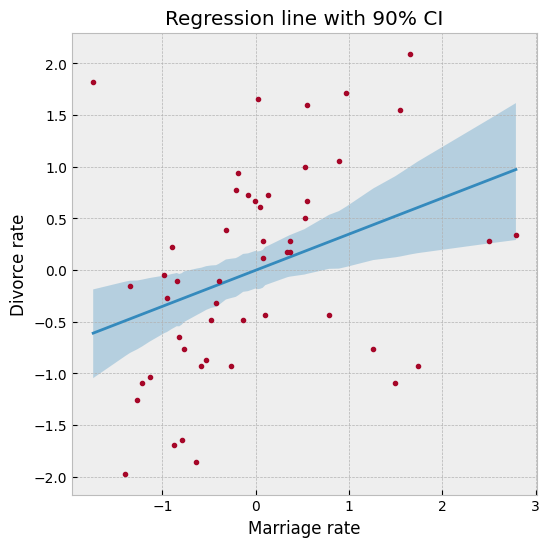

In [16]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort everything by corresponding x value
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, '.')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1) # converts shape from (2000,) -> (2000, 1)
    + jnp.expand_dims(samples_1["bM"], -1)*dset.MarriageScaled.values
)

mean_mu = posterior_mu.mean(axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate",
    ylabel="Divorce rate",
    title="Regression line with 90% CI"
)

We will use the `Predictive` class to sample from the prior predictive distribution.

[Text(0.5, 0, 'Marriage rate'),
 Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 1.0, 'Predictions with 90% CI')]

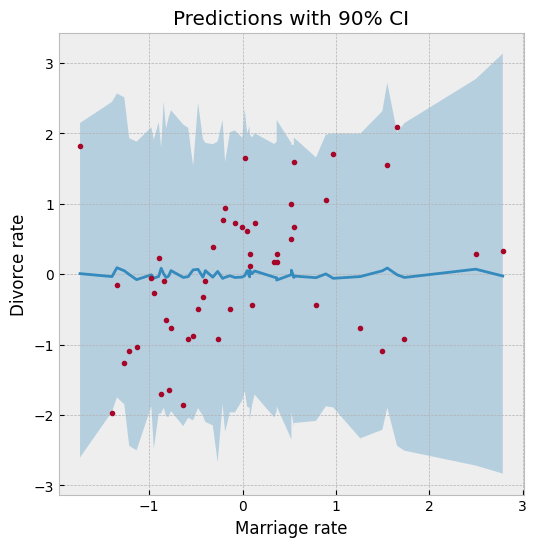

In [25]:
from numpyro.infer import Predictive
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
mean_prior_pred = prior_predictions.mean(axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(
    xlabel="Marriage rate",
    ylabel="Divorce rate",
    title="Predictions with 90% CI"
)

Next, still using `Predictive`, we will get samples from the posterior predictive distribution.

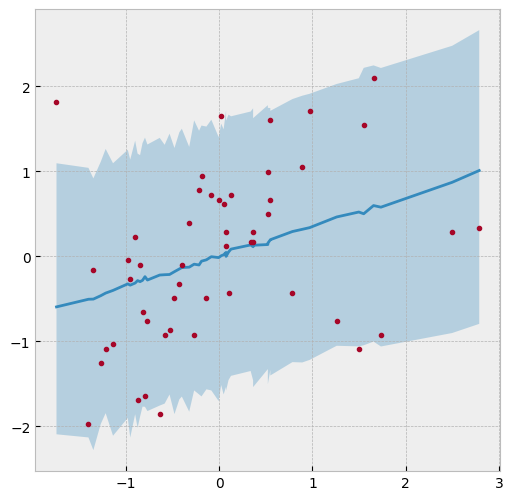

In [27]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
mean_pred = predictions.mean(axis=0)
hpdi_pred = hpdi(predictions, 0.9)
ax=plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)